In [15]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import bias_variance_decomp
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. load data, inspect and do exploratory plots

In [58]:
diabetes = datasets.load_diabetes()
X = diabetes.data
t = diabetes.target
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

In [60]:
# NumData, NumFeatures = X_train.shape
# print(NumData, NumFeatures)
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4)) 
# ax[0].hist(t, bins=40)
# ax[1].scatter(X[:,6], X[:,7], c='r', s=3) 
# ax[1].grid(True)
# plt.tight_layout()
# plt.savefig('exploratory_plot.png')
X[:,0]

array([ 0.03807591, -0.00188202,  0.08529891, -0.08906294,  0.00538306,
       -0.09269548, -0.04547248,  0.06350368,  0.04170844, -0.07090025,
       -0.09632802,  0.02717829,  0.01628068,  0.00538306,  0.04534098,
       -0.05273755, -0.00551455,  0.07076875, -0.0382074 , -0.02730979,
       -0.04910502, -0.0854304 , -0.0854304 ,  0.04534098, -0.06363517,
       -0.06726771, -0.10722563, -0.02367725,  0.05260606,  0.06713621,
       -0.06000263, -0.02367725,  0.03444337,  0.03081083,  0.01628068,
        0.04897352,  0.01264814, -0.00914709, -0.00188202, -0.00188202,
        0.00538306, -0.09996055, -0.06000263,  0.01991321,  0.04534098,
        0.02717829, -0.05637009, -0.07816532,  0.06713621, -0.04183994,
        0.03444337,  0.05987114, -0.05273755, -0.00914709, -0.04910502,
       -0.04183994, -0.04183994, -0.02730979,  0.04170844,  0.06350368,
       -0.07090025, -0.04183994, -0.02730979, -0.03457486,  0.06713621,
       -0.04547248, -0.00914709,  0.04170844,  0.03807591,  0.01

## fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
ax[0].hist(t, bins=40)
ax[1].scatter(X[:,6], X[:,7], c='m', s=3)
ax[1].grid(True)
plt.tight_layout()
plt.savefig("DiabetesTargetAndTwoInputs.jpg")

## 2. Compare pseudo-inverse to Linear Regression using sklearn

### Scatter plot

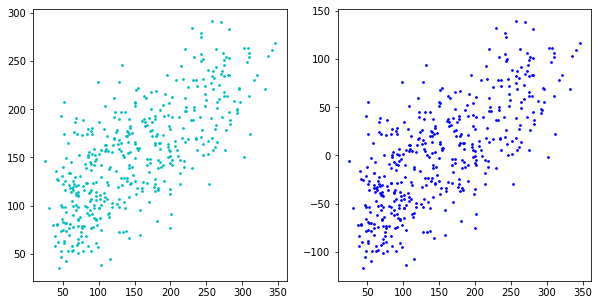

In [124]:
lr = LinearRegression()
lr.fit(X,t)
th1 = lr.predict(X)

w = np.linalg.inv(X.T @ X) @ X.T @ t
th2 = X @ w
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].scatter(t, th1, c='c', s=3)
ax[1].scatter(t, th2, c='b', s=3)
plt.savefig("pseudo_inverse_vs_LR.png")

## 3. Tikhanov (quadratic) Regularizer

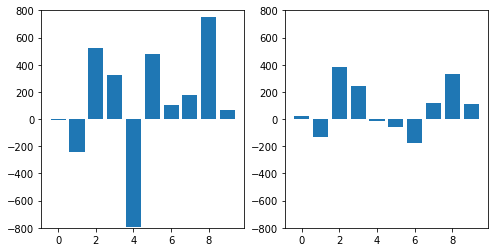

In [92]:
gamma = 0.5
wR = np.linalg.inv(X.T @ X + gamma*np.identity(NumFeatures)) @ X.T @ t

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].set_ylim(-800,800)
ax[1].set_ylim(-800,800)
ax[0].bar(np.arange(len(w)), w)

ax[1].bar(np.arange(len(wR)), wR)

plt.savefig("LeastSquaresAndRegularizedWeights.jpg")

## 4. Sparsity inducing (lasso) regularizer

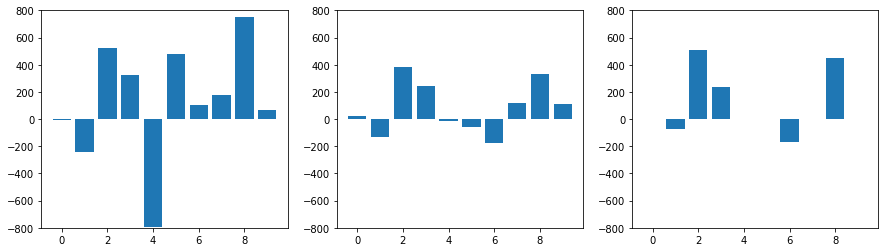

In [94]:
ll = Lasso(alpha=0.2)
ll.fit(X,t)
th_lasso = ll.predict(X)
w_lasso = ll.coef_
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
ax[0].set_ylim(-800,800)
ax[1].set_ylim(-800,800)
ax[2].set_ylim(-800,800)
ax[0].bar(np.arange(len(w)), w)
ax[1].bar(np.arange(len(wR)), wR)
ax[2].bar(np.arange(len(w_lasso)), w_lasso)
plt.savefig("NoR_L2_L1.png")
# some of the small params are pushed to 0, called sparse solution

In [178]:

alpha = np.linspace(0.01,5,30)
n_error = []
n_nonzero = []
n_bias = []
n_var = []
for i in alpha:
    ll = Lasso(alpha=i)
#     mse, bias, var = bias_variance_decomp(ll, X_train, t_train, X_test, t_test
#                                       , loss='mse', num_rounds=200, random_seed=1)
    ll.fit(X_train,t_train)
    wl = ll.coef_
    t_pred = ll.predict(X_test)
    var=np.var(t_pred)
    sse=np.mean((np.mean(t_pred)-t_test)**2)
    bias = sse-var
    n_nonzero.append(len(wl[wl!=0]))
    n_error.append(sse)
    n_bias.append(bias)
    n_var.append(var)
    


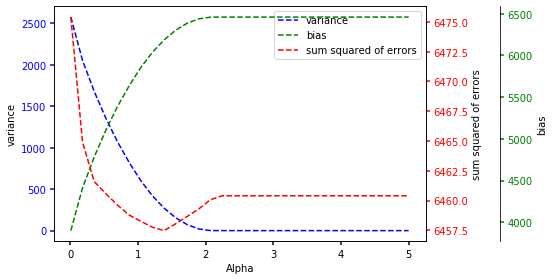

<Figure size 432x288 with 0 Axes>

In [207]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
p1, = ax1.plot(alpha, n_var,'b--', label='variance')
p2, = ax2.plot(alpha, n_bias, 'g--',label='bias')
p3, = ax3.plot(alpha, n_error, 'r--',label='sum squared of errors')

# ax2.legend(loc='upper right')
# ax1.set_xlim(0, 5)
# ax1.set_ylim(0, 2500)
# ax2.set_ylim(1500, 2500)
# ax3.set_ylim(0, 2500)
ax1.set_xlabel("Alpha")
ax1.set_ylabel("variance")
ax2.set_ylabel("bias")
ax3.set_ylabel("sum squared of errors")
tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)
# ax3.legend(loc='upper left')
lines = [p1, p2, p3]
ax1.legend(lines, [l.get_label() for l in lines])
fig.tight_layout() 
plt.show()
plt.savefig('bias_variance_tradeoff.png')

[2576.491232054012,
 2055.4968172941767,
 1681.966128832751,
 1358.0453757402909,
 1072.8628451336167,
 824.2501899870209,
 603.8703299971189,
 419.9002495861028,
 271.7741285395391,
 155.25159937944883,
 71.20363232588313,
 19.635652163439154,
 0.46791203360173655,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28,
 8.077935669463161e-28]

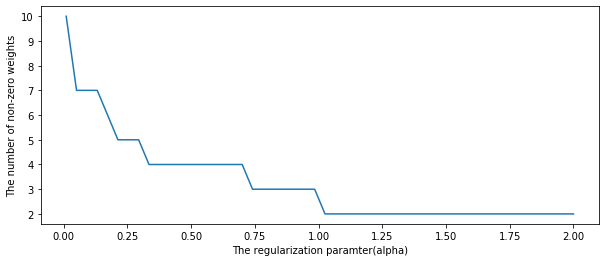

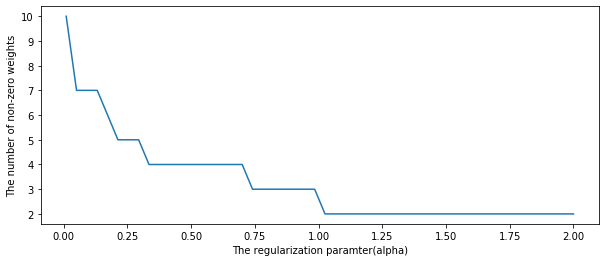

In [112]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(alpha, n_nonzero)
ax.set_xlabel('The regularization paramter(alpha)')
ax.set_ylabel("The number of non-zero weights")
plt.savefig("The number of non-zero weights change with the regularization parameters")
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(alpha, n_nonzero)
ax.set_xlabel('The regularization paramter(alpha)')
ax.set_ylabel("The number of non-zero weights")
plt.savefig("The number of non-zero weights change with the regularization parameters")

In [114]:

mse, bias, var = bias_variance_decomp(model, X_train, y_train, X_test, y_test
                                      , loss='mse', num_rounds=200, random_seed=1)

## 5. Lasso Regularization path on a synthetic example (Set up data):

In [8]:
%matplotlib inline
from sklearn.linear_model import lasso_path
# Synthetic data:
# Problem taken from Hastie, et al., Statistical Learning with Sparsity # Z1, Z2 ~ N(0,1)
# Y = 3*Z1 -1.5*Z2 + 10*N(0,1) Noisy response
# Noisy inputs (the six are in two groups of three each)
# Xj= Z1 + 0.2*N(0,1) for j = 1,2,3
# Xj= Z2 + 0.2*N(0,1) for j = 4,5,6

N = 100
y = np.empty(0)
print(y)
X = np.empty([0,6])
print(X)
for i in range(N):
    Z1 = np.random.randn()
    Z2 = np.random.randn()
    y = np.append(y, 3*Z1 - 1.5*Z2 + 2*np.random.randn())
    Xarr = np.array([Z1,Z1,Z1,Z2,Z2,Z2]) + np.random.randn(6)/5
    X = np.vstack((X, Xarr.tolist()))
    
print(X.shape)
print(y.shape)

[]
[]
(100, 6)
(100,)


## 6. Lasso Regularization path on a synthetic example (Regression and paths):

Text(0, 0.5, 'Regression Coefficients')

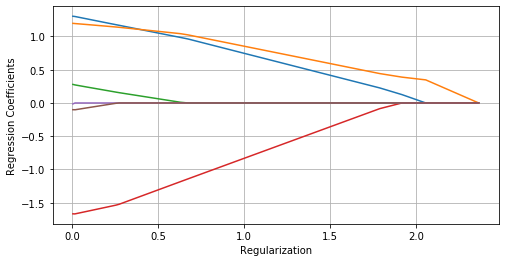

In [9]:
# Compute regressions with Lasso and return paths
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, fit_intercept=False)
fig, ax = plt.subplots(figsize=(8,4))
for i in range(6):
    ax.plot(alphas_lasso, coefs_lasso[i,:])
    
ax.grid(True)
ax.set_xlabel("Regularization")
ax.set_ylabel("Regression Coefficients")


## 7. Predicting Solubility of Chemical Compounds

In [29]:
# sol = pd.read_excel("Husskonen_Solubility_Features.xlsx", verbose=False)
# print(sol.shape)
# print(sol.columns)
# np.cov(sol['LogS.M.'],sol['nCIC'])
sol

,0,Compound_Identifier,Source,SMILES,LogS.M.,MW,AMW,Sv,Se,Sp,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,1,HU_100,Huuskonen,c1ccc2ccc3nccnc3c2c1,-2.68,180.22,8.192,15.623,21.854,16.296,...,0,0,0,0,1,0,1,0,1,0
1,2,HU_1000,Huuskonen,c1cnc2c(C)ncnc2n1,-0.12,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
2,3,HU_1001,Huuskonen,c1cnc2cnc(C)nc2n1,-0.47,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
3,4,HU_1002,Huuskonen,c1c(C)nc2cncnc2n1,0.06,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
4,5,HU_1003,Huuskonen,c1cnc2c(OC)ncnc2n1,-1.11,162.17,9.009,12.327,18.618,12.239,...,0,0,0,0,0,0,0,0,0,0
5,6,HU_1004,Huuskonen,c1cnc2cnc(OC)nc2n1,-1.11,162.17,9.009,12.327,18.618,12.239,...,0,0,0,0,0,0,0,0,0,0
6,7,HU_1005,Huuskonen,c1c(OC)nc2cncnc2n1,-0.91,162.17,9.009,12.327,18.618,12.239,...,0,0,0,0,0,0,0,0,0,0
7,8,HU_1006,Huuskonen,c1cnc2c(SC)ncnc2n1,-1.76,178.24,9.902,12.800,18.367,13.432,...,0,0,0,0,0,0,0,0,1,0
8,9,HU_1007,Huuskonen,c1cnc2cnc(SC)nc2n1,-2.36,178.24,9.902,12.800,18.367,13.432,...,0,0,0,0,0,0,0,0,1,0
9,10,HU_1008,Huuskonen,c1c(SC)nc2cncnc2n1,-1.55,178.24,9.902,12.800,18.367,13.432,...,0,0,0,0,0,0,0,0,1,0


932 2256


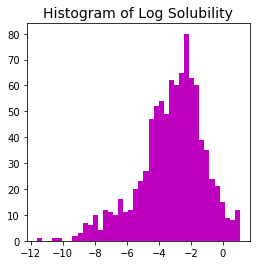

In [31]:
t = sol["LogS.M."].values
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(t, bins=40, facecolor='m')
ax.set_title("Histogram of Log Solubility", fontsize=14)
X = sol[sol.columns[5:len(sol.columns)]]
N, p = X.shape
print(N, p)

In [32]:
# train test split

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

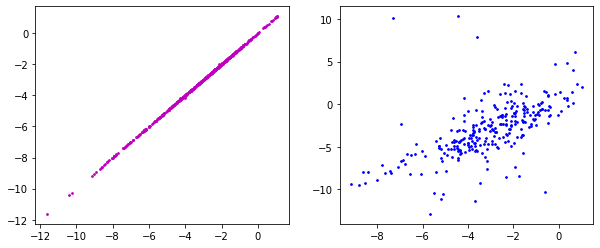

In [33]:
lr = LinearRegression()
lr.fit(X_train, t_train)
th_train=lr.predict(X_train)
th_test=lr.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(t_train, th_train, c='m', s=3)
ax[1].scatter(t_test, th_test, c='b', s=3)
plt.savefig("Predicted solubilities against the true solubilities on the training and test sets.png")

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152.79431120682557, tolerance: 0.2729942622546013
  positive)


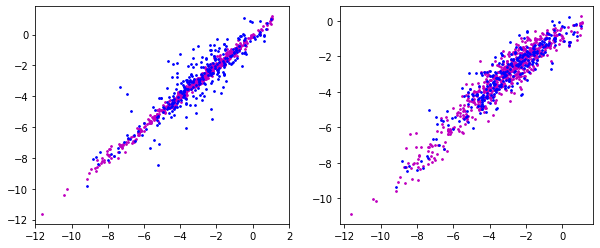

In [34]:
# regularized regression
gamma = 2.3
w = np.linalg.inv(X_train.T @ X_train + gamma*np.identity(p)) @ X_train.T @ t_train
th_train = X_train @ w.to_numpy()
th_test = X_test @ w.to_numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].set_xlim(-12,2)
ax[0].scatter(t_train, th_train, c='m', s=3)
# ax[1].set_xlim(-12,2)
ax[0].scatter(t_test, th_test, c='b', s=3)

from sklearn.linear_model import Lasso
ll = Lasso(alpha=0.2)
ll.fit(X_train,t_train)
th_train=ll.predict(X_train)
th_test=ll.predict(X_test)
# w_lasso = np.linalg.inv(X_train @ X_train.T)@(X_train.T@t_train + gamma/2)
# tl_train = X_train @ w_lasso.to_numpy()
# tl_test = X_test @ w_lasso.to_numpy()
ax[1].scatter(t_train, th_train, c='m', s=3)
ax[1].scatter(t_test, th_test, c='b', s=3)


In [49]:
# from sklearn.metrics import mean_squared_error
# alpha = np.linspace(0.1,50,50)
# n_error = []
# n_nonzero = []
# for i in alpha:
#     ll = Lasso(alpha=i)
#     ll.fit(X_train,t_train)
#     wl = ll.coef_
#     n_nonzero.append(len(wl[wl!=0]))
#     th_test=ll.predict(X_test)
#     error = mean_squared_error(t_test, th_test)
#     n_error.append(error)
    
alpha = np.linspace(0.01,50,100)
n_error = []
n_nonzero = []
n_bias = []
n_var = []
n_score = []
n_score_train = []
for i in alpha:
    ll = Lasso(alpha=i)
#     mse, bias, var = bias_variance_decomp(ll, X_train, t_train, X_test, t_test
#                                       , loss='mse', num_rounds=200, random_seed=1)
    ll.fit(X_train,t_train)
    wl = ll.coef_
    t_pred = ll.predict(X_test)
    score= ll.score(X_test, t_test)
    score_train= ll.score(X_train, t_train)
    var=np.var(t_pred)
    sse=np.mean((np.mean(t_pred)-t_test)**2)
    bias = sse-var
    n_nonzero.append(len(wl[wl!=0]))
    n_error.append(sse)
    n_bias.append(bias)
    n_var.append(var)
    n_score.append(score)
    n_score_train.append(score_train)

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.17574204965634, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.6204877681709, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.59732641914428, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective 

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.889650266052172, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.160430553408219, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.561367195668254, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.53461316563687, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.078914373801126, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6713329188714852, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective d

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.447852732629144, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.519641762092988, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.581923448146654, tolerance: 0.2729942622546013
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective d

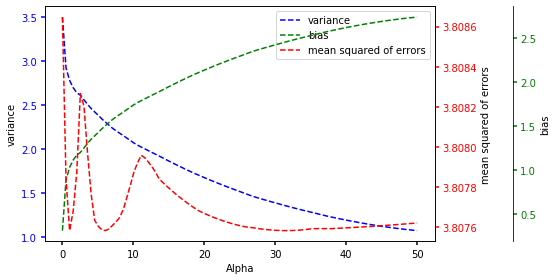

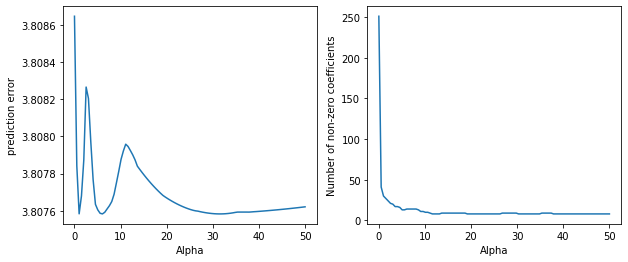

In [36]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
p1, = ax1.plot(alpha, n_var,'b--', label='variance')
p2, = ax2.plot(alpha, n_bias, 'g--',label='bias')
p3, = ax3.plot(alpha, n_error, 'r--',label='mean squared of errors')

# ax2.legend(loc='upper right')
# ax1.set_xlim(0, 5)
# ax1.set_ylim(0, 2500)
# ax2.set_ylim(1500, 2500)
# ax3.set_ylim(0, 2500)
ax1.set_xlabel("Alpha")
ax1.set_ylabel("variance")
ax2.set_ylabel("bias")
ax3.set_ylabel("mean squared of errors")
tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)
# ax3.legend(loc='upper left')
lines = [p1, p2, p3]
ax1.legend(lines, [l.get_label() for l in lines])
fig.tight_layout() 

plt.savefig('bias_variance_tradeoff.png')
# np.linalg.inv(X.T @ X)
# wh = list(w)
# sol.columns[wh.index(w.max())]
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(10,4))
ax[0].plot(alpha, n_error)
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("prediction error")
ax[1].plot(alpha, n_nonzero)
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Number of non-zero coefficients")
plt.savefig("how the prediction error (on the test data) and the corresponding number of non-zero coefficients change with increasing regularization.png")


0.6549202091627481
0.739425309759387


/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.127928256199084, tolerance: 0.2729942622546013
  positive)


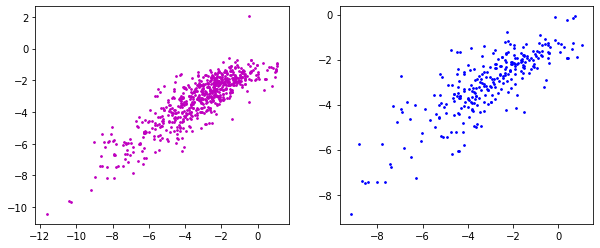

In [50]:
# print(n_score)
# print(alpha)
ll = Lasso(alpha[19])
ll.fit(X_train,t_train)
print(n_score[19])
print(n_score_train[19])
wl = ll.coef_
# print(sol[sol.columns[5:len(sol.columns)]].columns[wl!=0])
# len(wl[wl!=0])
th_train = ll.predict(X_train)
pred = ll.predict(X_test)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(t_train, th_train, c='m', s=3)
ax[1].scatter(t_test, pred, c='b', s=3)

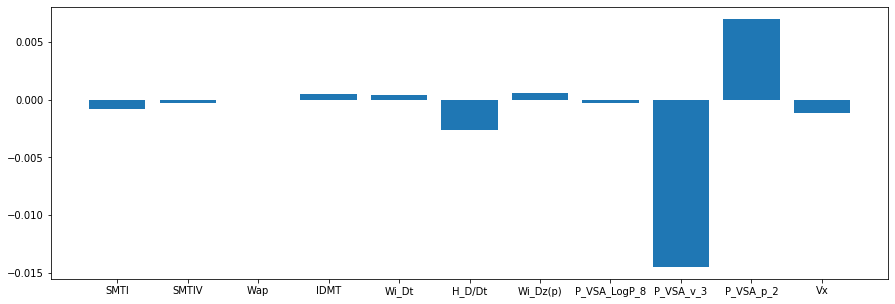

In [38]:
w_10 = wl[wl!=0]
fig,ax = plt.subplots(figsize=(15,5))
ax.bar(sol[sol.columns[5:len(sol.columns)]].columns[wl!=0], w_10)
plt.savefig("top ten featres to predict solubility.png")

In [293]:
# Using all features
lr = LinearRegression()
lr.fit(X_train,t_train)
pred = lr.predict(X_test)
print("mse using all features", mean_squared_error(t_test, pred))
ll = Lasso(alpha=12)
ll.fit(X_train,t_train)
pred = ll.predict(X_test)
print("mse using top 10 features", mean_squared_error(t_test, pred))


mse using all features 1.836738410641526
mse using top 10 features 1.258413639168866


/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.427486109555502, tolerance: 0.2699260586963191
  positive)


In [80]:
# using a quadratic regularizer
gamma = 2.3
w = np.linalg.inv(X_train.T @ X_train + gamma*np.identity(p)) @ X_train.T @ t_train
th_train = X_train @ w.to_numpy()
th_test = X_test @ w.to_numpy()
mean_squared_error(t_test, th_test)

1.0173819876223429

In [42]:
print(n_nonzero)
print(alpha)

[251, 41, 30, 27, 24, 21, 20, 17, 17, 16, 13, 13, 14, 14, 14, 14, 14, 13, 11, 11, 10, 10, 9, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
[1.00000000e-02 5.14949495e-01 1.01989899e+00 1.52484848e+00
 2.02979798e+00 2.53474747e+00 3.03969697e+00 3.54464646e+00
 4.04959596e+00 4.55454545e+00 5.05949495e+00 5.56444444e+00
 6.06939394e+00 6.57434343e+00 7.07929293e+00 7.58424242e+00
 8.08919192e+00 8.59414141e+00 9.09909091e+00 9.60404040e+00
 1.01089899e+01 1.06139394e+01 1.11188889e+01 1.16238384e+01
 1.21287879e+01 1.26337374e+01 1.31386869e+01 1.36436364e+01
 1.41485859e+01 1.46535354e+01 1.51584848e+01 1.56634343e+01
 1.61683838e+01 1.66733333e+01 1.71782828e+01 1.76832323e+01
 1.81881818e+01 1.86931313e+01 1.91980808e+01 1.97030303e+01
 2.02079798e+01 2.07129293e+01 2.12178788e+01 2.17228283e+01
 2.22

In [85]:
ll = Lasso(alpha=12)
ll.fit(X_train,t_train)
wl = ll.coef_
len(wl[wl!=0])

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.171223522234868, tolerance: 0.2692739071779142
  positive)


8

In [278]:
 w_10

array([-1.33107143e-03, -2.26795929e-05, -2.35473258e-05,  1.82902531e-05,
        5.75287918e-04, -1.30012996e-03,  4.51047234e-04, -2.49217560e-04,
       -1.68207224e-02,  5.44742995e-03])

In [280]:
alpha = np.linspace(0.01,50,100)
n_nonzero = []
for i in alpha:
    ll = Lasso(alpha=i)
    ll.fit(X_train,t_train)
    wl = ll.coef_
    n_nonzero.append(len(wl[wl!=0]))

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.58046739162228, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.80379993034936, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.25596828140846, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objectiv

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.368427920894305, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.49461785463302, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.066049920164687, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective di

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.30352599287221, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.764930051935494, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.771442015057005, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective

/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.549415222144944, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.56464312554067, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.567373623517142, tolerance: 0.2699260586963191
  positive)
/Users/zhangyan/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective

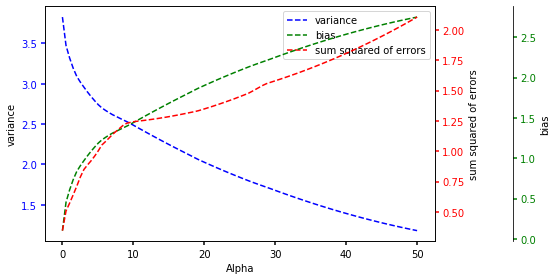

<Figure size 432x288 with 0 Axes>

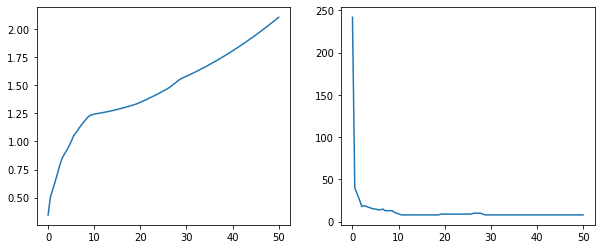

In [281]:
        
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(ax3)
ax3.spines["right"].set_visible(True)
p1, = ax1.plot(alpha, n_var,'b--', label='variance')
p2, = ax2.plot(alpha, n_bias, 'g--',label='bias')
p3, = ax3.plot(alpha, n_error, 'r--',label='sum squared of errors')

# ax2.legend(loc='upper right')
# ax1.set_xlim(0, 5)
# ax1.set_ylim(0, 2500)
# ax2.set_ylim(1500, 2500)
# ax3.set_ylim(0, 2500)
ax1.set_xlabel("Alpha")
ax1.set_ylabel("variance")
ax2.set_ylabel("bias")
ax3.set_ylabel("sum squared of errors")
tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)
# ax3.legend(loc='upper left')
lines = [p1, p2, p3]
ax1.legend(lines, [l.get_label() for l in lines])
fig.tight_layout() 
plt.show()
plt.savefig('bias_variance_tradeoff.png')
# np.linalg.inv(X.T @ X)
# wh = list(w)
# sol.columns[wh.index(w.max())]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].plot(alpha, n_error)
ax[1].plot(alpha, n_nonzero)